In [78]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import requests
import statsmodels
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn
import dateutil
from datetime import datetime
import math
import plotly.graph_objects as go
import plotly.express as px
import math
import functions.functions as base_fx
import functions.portfolio_functions as portfolio_fx
import functions.algorithms as algos
import importlib


In [294]:
importlib.reload(base_fx)
importlib.reload(portfolio_fx)
importlib.reload(algos)

<module 'functions.algorithms' from '../functions/algorithms.py'>

In [314]:
symbols = ['XRPBTC', 'BNBBTC']
#['XRPBTC','ETHBTC', 'ADABTC', 'BCHBTC', 'DASHBTC', 'EOSBTC', 'NEOBTC', 'BNBBTC', 'LTCBTC', 'IOTABTC']

#['ETH-USD.CC','BTC-USD.CC','XRP-USD.CC','ANT-USD.CC','ARDR-USD.CC','ARK-USD.CC','ATB-USD.CC','BAT-USD.CC','BCCOIN-USD.CC','BCH-USD.CC','BCN-USD.CC','BLOCK-USD.CC','BNB-USD.CC','BNT-USD.CC','BTCD-USD.CC','BTC-USD.CC','BTG-USD.CC','BTM-USD.CC','BTS-USD.CC','CVC-USD.CC','DASH-USD.CC','DCN-USD.CC','DCR-USD.CC','DGB-USD.CC','DGD-USD.CC','DNT-USD.CC','DOGE-USD.CC','EDG-USD.CC','EOS-USD.CC','ETC-USD.CC','ETH-USD.CC','ETP-USD.CC','FAIR-USD.CC','FCT-USD.CC','FRST-USD.CC','FUN-USD.CC','GAME-USD.CC','GAS-USD.CC','GBYTE-USD.CC','GNO-USD.CC','GNT-USD.CC','HSR-USD.CC','ICN-USD.CC','ICX-USD.CC','IOC-USD.CC','IOT-USD.CC','KMD-USD.CC','KNC-USD.CC','LINK-USD.CC','LKK-USD.CC','LRC-USD.CC','LSK-USD.CC','LTC-USD.CC','MAID-USD.CC','MCAP-USD.CC','MCO-USD.CC','MGO-USD.CC','MLN-USD.CC','MONA-USD.CC','MTL-USD.CC','NAV-USD.CC','NEBL-USD.CC','NEO-USD.CC','NLC2-USD.CC','NXS-USD.CC','NXT-USD.CC','OMG-USD.CC','PART-USD.CC','PAY-USD.CC','PIVX-USD.CC','PPT-USD.CC','QASH-USD.CC','QRL-USD.CC','QTUM-USD.CC','REP-USD.CC','RLC-USD.CC','SALT-USD.CC','SC-USD.CC','SMART-USD.CC','SNGLS-USD.CC','SNM-USD.CC','SNT-USD.CC','STEEM-USD.CC','STORJ-USD.CC','STRAT-USD.CC','SUB-USD.CC','SYS-USD.CC','TAAS-USD.CC','TRX-USD.CC','UBQ-USD.CC','USDT-USD.CC','VERI-USD.CC','VTC-USD.CC','WAVES-USD.CC','WINGS-USD.CC','WTC-USD.CC','XCP-USD.CC','XEM-USD.CC','XLM-USD.CC','XMR-USD.CC','XRP-USD.CC','XUC-USD.CC','XVG-USD.CC','XZC-USD.CC','ZEC-USD.CC','ZEN-USD.CC','ZRX-USD.CC']


# Get Data

In [337]:
quotes = pd.DataFrame()
quotes_df = pd.DataFrame()

#start = '2011-06-1' ## Starts with non-correlated period (drops 40% at the start)
start_date = datetime.strptime('2019-01-1', '%Y-%m-%d')
start = int(datetime.timestamp(start_date)) * 1000
print(start)
end_date = datetime.strptime('2020-04-05','%Y-%m-%d')
end = int(datetime.timestamp(end_date)) * 1000
print(end)


1546297200000
1586037600000


In [338]:
while start < end:
    print(start)
    for s in symbols:
        #print(s)
        endpoint = f'https://api.binance.com/api/v3/klines?symbol={s}&interval=1h&startTime={start}'
        res = requests.get(endpoint)
        data = res.content
        res_df = pd.read_json(data)
        df = pd.DataFrame()
       # print(start)
        df['Date'] = pd.to_datetime(res_df[0], unit='ms')
        df['Adjusted_close'] = res_df[4]
        #print(df)
        df = df[df['Adjusted_close'] > 0]
        if len(quotes_df) == 0:
            quotes_df['Date'] = df['Date']
            quotes_df[s] = df['Adjusted_close']
        else:
            new_df = pd.DataFrame()
            new_df['Date'] = df['Date']
            new_df[s] = df['Adjusted_close']
            quotes_df = quotes_df.merge(new_df, how="inner", on="Date")
            
    quotes_df.set_index('Date', inplace=True)
        
    if len(quotes) == 0:
        quotes = quotes_df
       # print(quotes)
    else:
        quotes = pd.concat([quotes,quotes_df], axis=0, join='inner')
       # print(quotes)
    quotes = quotes.loc[~quotes.index.duplicated(keep='first')]

    quotes_df = pd.DataFrame()
    start = int(datetime.timestamp(quotes.index[-1])) * 1000
    #print(quotes)
    #start = quotes['Date'][-1].tail(1)
    
        #print(quotes.head(10))
#print(quotes.tail(20))

1546297200000
1548090000000
1549882800000
1551675600000
1553490000000
1555279200000
1557068400000
1558893600000
1560682800000
1562472000000
1564261200000
1566079200000
1567868400000
1569657600000
1571446800000
1573239600000
1575046800000
1576839600000
1578632400000
1580425200000
1582239600000
1584036000000
1585825200000


In [339]:
#print(quotes['ADA-USD.CC'].index[0] <= '2019-02-01')

In [340]:
old_quotes = quotes
#print(quotes)


In [341]:
quotes = quotes.dropna()
quotes = quotes.reset_index()
quotes['Date'] = pd.to_datetime(quotes['Date'])
quotes = quotes.set_index('Date')
#quotes = quotes[quotes.index > dateutil.parser.parse("2020-03-01")]
#print(quotes)

In [342]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

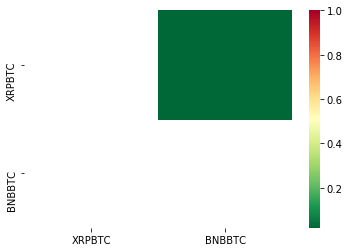

[('XRPBTC', 'BNBBTC')]


In [343]:
data = quotes
scores, pvalues, pairs = find_cointegrated_pairs(data)
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=data.columns, 
                yticklabels=data.columns, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.80)
                )
plt.show()
print(pairs)

# Params

In [344]:
symbol1 = 'XRPBTC'
symbol2 = 'BNBBTC'

In [353]:
# Indicators
macd_fast_points = 1
macd_slow_points = 2
max_leverage = 2

# Could be changed
mavg_1 = 5 # default 5
mavg_2 = 40 #default 60

## Optimize trading limits looking at zscore
limit = 1 #default 1
exit_limit = 0.75 #default -.75
leverage_limit = 1.2

## Optimize these with bruteforce
vol_interval = 12 # default 30: good -12
vol_peak_period = 24*7 # default 365 : good - 24*7
vol_mean_peak_period = 24 * 2# default 60: good - 24 *2
coint_period = 24 # good - 24
coint_limit = 0.2 # good 02


In [354]:
settings = {
    'symbol1': symbol1,
    'symbol2': symbol2,
    'mavg_1' : mavg_1,
    'mavg_2': mavg_2,
    'macd_fast_points': macd_fast_points,
    'macd_slow_points': macd_slow_points,
    'vol_interval': vol_interval,
    'vol_peak_period': vol_peak_period,
    'vol_mean_peak_period': vol_mean_peak_period,
    'limit': limit,
    'leverage_limit': leverage_limit,
    'exit_limit': exit_limit,
    'max_leverage': max_leverage,
    'coint_limit': coint_limit,
    'coint_period': coint_period
}

In [355]:
portfolio, mavg_zscore = algos.pair_trade_with_zscore_limit(settings, quotes)

Return: 
27.821913989949888%
Vol:
0.015055221467928342


In [348]:
portfolio_fx.plot_trades_on_zscore_for_symbol(mavg_zscore, portfolio, symbol2)

In [349]:
print(portfolio['history'])

     symbol  type       amount  bought_at           bought_on status  \
0    XRPBTC   BUY  5000.000000   0.000094 2019-01-04 20:00:00  CLOSE   
1    BNBBTC  SELL  5000.000000   0.001586 2019-01-04 20:00:00  CLOSE   
2    XRPBTC   BUY  5064.324769   0.000090 2019-01-11 22:00:00  CLOSE   
3    BNBBTC  SELL  5064.324769   0.001635 2019-01-11 22:00:00  CLOSE   
4    XRPBTC  SELL  5038.382307   0.000091 2019-01-14 02:00:00  CLOSE   
5    BNBBTC   BUY  5038.382307   0.001607 2019-01-14 02:00:00  CLOSE   
6    XRPBTC   BUY  5079.081395   0.000090 2019-01-15 04:00:00  CLOSE   
7    BNBBTC  SELL  5079.081395   0.001633 2019-01-15 04:00:00  CLOSE   
8    XRPBTC   BUY  5066.679353   0.000091 2019-01-17 00:00:00  CLOSE   
9    BNBBTC  SELL  5066.679353   0.001681 2019-01-17 00:00:00  CLOSE   
10   XRPBTC   BUY  5049.035724   0.000090 2019-01-17 12:00:00  CLOSE   
11   BNBBTC  SELL  5049.035724   0.001695 2019-01-17 12:00:00  CLOSE   
12   XRPBTC   BUY  5080.865378   0.000088 2019-01-20 08:00:00  C